In [24]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [25]:
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [26]:
def bmi_convert(bmi):
    if bmi < 18.5:
        return 0
    if 18.5 <= bmi < 25:
        return 1
    if 25 <= bmi < 30:
        return 2
    if 30 <= bmi:
        return 3

In [27]:
def have_same_prefix(str1, str2):
    words_1 = str1.split("&")
    words_2 = str2.split("&")
    for i in range(len(words_1) - 1):
        if words_1[i] != words_2[i]:
            return False
    return True

def generate_new_name(str1, str2):
    words_1 = str1.split("&")
    words_2 = str2.split("&")
    new_str = ""
    for i in range(len(words_1)):
        new_str += words_1[i] + "&"
        if i == len(words_1) - 1:
            new_str += words_2[-1]
    return new_str

In [28]:
df = pd.read_csv("./diabetes_binary_health_indicators_BRFSS2015.csv")
df = df.astype(int)
df["BMI"] = df["BMI"].map(bmi_convert)
df["Male"] = df["Sex"]
df["Female"] = df["Sex"].map(lambda x: 1 - x)
df_new = df[["Diabetes_binary", "HighBP", "HighChol", "CholCheck", "BMI", "Smoker", "Stroke", "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "GenHlth", "DiffWalk", "Male", "Female", "Age"]]

cat_columns = ["BMI", "GenHlth", "Age"]
encoder = OneHotEncoder()
X = encoder.fit_transform(df_new[cat_columns]).toarray()
df_new.drop(cat_columns, axis=1, inplace=True)
new_columns = []
categories = encoder.categories_
for i in range(len(categories)):
    nc = list(categories[i])
    nc = [cat_columns[i] + "_" + str(val) for val in nc]
    new_columns += nc

X = X.astype(int)
one_hot = pd.DataFrame(X, columns=new_columns)
df_new = pd.concat([one_hot, df_new], axis=1)

/var/folders/fc/9w7nbmnj2y10_sl912glk3240000gn/T/ipykernel_35486/1557338452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(cat_columns, axis=1, inplace=True)


In [29]:
df_save = df_new.copy()

In [30]:
minconf = df_new["Diabetes_binary"].sum(axis=0) / len(df_new)
all_candidates = []
all_frequent_itemsets = []
candidates_k = list(df_new.columns)
candidates_k.remove("Diabetes_binary")
remove_list = []
for c in candidates_k:
    df_new[c] = df_new[c] & df_new["Diabetes_binary"]
    temp_conf = df_new[c].sum(axis=0) / df_save[c].sum(axis=0)
    if temp_conf < minconf:
        remove_list.append(c)
for c in remove_list:
    candidates_k.remove(c)

In [31]:
for _ in range(2):
    new_candidates = []
    for i in range(len(candidates_k)):
        for j in range(i + 1, len(candidates_k)):
            if have_same_prefix(candidates_k[i], candidates_k[j]):
                temp_vector = df_new[candidates_k[i]] & df_new[candidates_k[j]]
                temp_pop = df_save[candidates_k[i]] & df_save[candidates_k[j]]
                temp_conf = temp_vector.sum(axis=0) / temp_pop.sum(axis=0)
                if temp_conf >= minconf:
                    column_name = generate_new_name(candidates_k[i], candidates_k[j])
                    df_new[column_name] = temp_vector.copy()
                    df_save[column_name] = temp_pop.copy()
                    new_candidates.append(column_name)
    all_candidates.append(candidates_k)
    candidates_k = new_candidates


In [32]:
k = 2

In [33]:
text = ""
for i in range(k):
    candidates = all_candidates[i]
    for c in candidates:
        vector = df_new[c]
        pop = df_save[c]
        conf = vector.sum(axis=0) / pop.sum(axis=0)
        text += f"{c} = {round(conf * 100, 2)}%\n"

In [34]:
file = open("./confidence.txt", 'w')
file.write(text)
file.close()

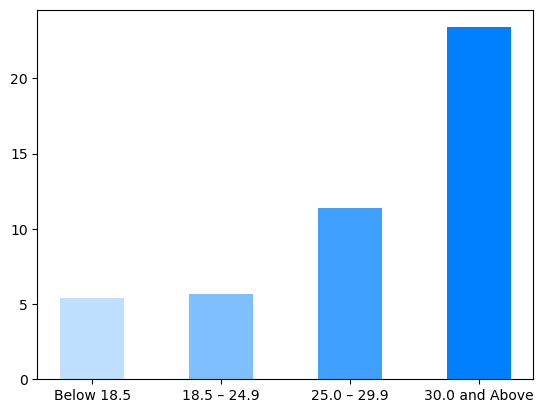

In [35]:
from matplotlib import cm

columns = ["BMI_0", "BMI_1", "BMI_2", "BMI_3"]
colors = [(0,0.5,1,0.25), (0,0.5,1,0.5), (0,0.5,1,0.75), (0,0.5,1,1)]
names = ["Below 18.5", "18.5 – 24.9", "25.0 – 29.9", "30.0 and Above"]
for i in range(len(columns)):
    vector = df_new[columns[i]]
    pop = df_save[columns[i]]
    conf = vector.sum(axis=0) / pop.sum(axis=0)
    plt.bar(names[i], round(conf*100, 2), color=colors[i], width=0.5)

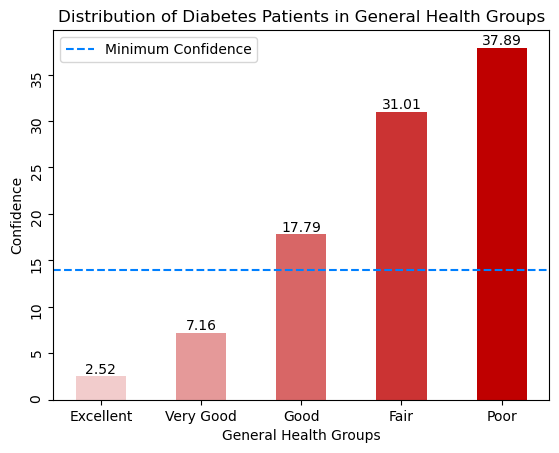

In [36]:
healths = list(df["GenHlth"].unique())
names = ["Excellent", "Very Good", "Good", "Fair", "Poor"]
healths.sort()


for i in range(len(healths)):
    c = f"GenHlth_{healths[i]}"
    vector = df_new[c]
    pop = df_save[c]
    conf = vector.sum(axis=0) / pop.sum(axis=0)
    bar = plt.bar(names[i], round(conf*100, 2), color=(0.75,0,0,(i+1)/len(healths)), width=0.5)
    plt.bar_label(bar)
plt.axhline(y=round(minconf*100, 2), color=(0,0.5,1), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("General Health Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Diabetes Patients in General Health Groups")
plt.legend(loc="upper left")
plt.show()

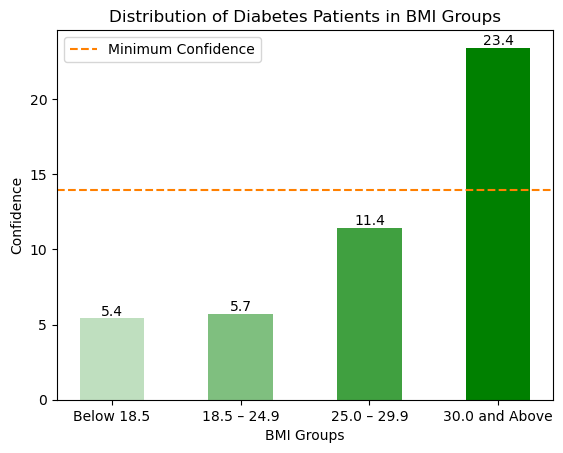

In [37]:
columns = ["BMI_0", "BMI_1", "BMI_2", "BMI_3"]
names = ["Below 18.5", "18.5 – 24.9", "25.0 – 29.9", "30.0 and Above"]
for i in range(len(columns)):
    vector = df_new[columns[i]]
    pop = df_save[columns[i]]
    conf = vector.sum(axis=0) / pop.sum(axis=0)
    bar = plt.bar(names[i], round(conf*100, 2), color=(0,0.5,0,(i+1)/len(columns)), width=0.5)
    plt.bar_label(bar)
plt.axhline(y=round(minconf*100, 2), color=(1,0.5,0), linestyle='dashed', label="Minimum Confidence")
plt.xlabel("BMI Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Diabetes Patients in BMI Groups")
plt.legend(loc="upper left")
plt.show()

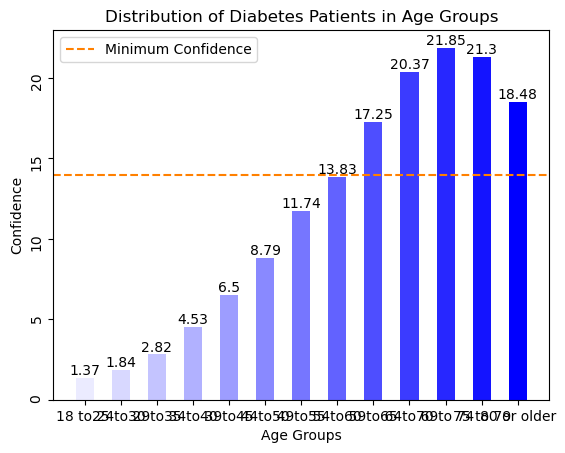

In [38]:
ages = list(df["Age"].unique())
names = ["18 to 24", "25 to 29", "30 to 34", "35 to 39", "40 to 44", "45 to 49",
         "50 to 54", "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 or older"]
ages.sort()

for i in range(len(ages)):
    c = f"Age_{ages[i]}"
    vector = df_new[c]
    pop = df_save[c]
    conf = vector.sum(axis=0) / pop.sum(axis=0)
    bar = plt.bar(names[i], round(conf*100, 2), color=(0,0,1,(i+1)/len(ages)), width=0.5)
    plt.bar_label(bar)
    # plt.bar(names[i], round(minconf*100, 2), color=(1,0.5,0,(i+1)/len(ages)), width=0.5)
plt.axhline(y=round(minconf*100, 2), color=(1,0.5,0), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("Age Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Diabetes Patients in Age Groups")
plt.legend(loc="upper left")
plt.show()

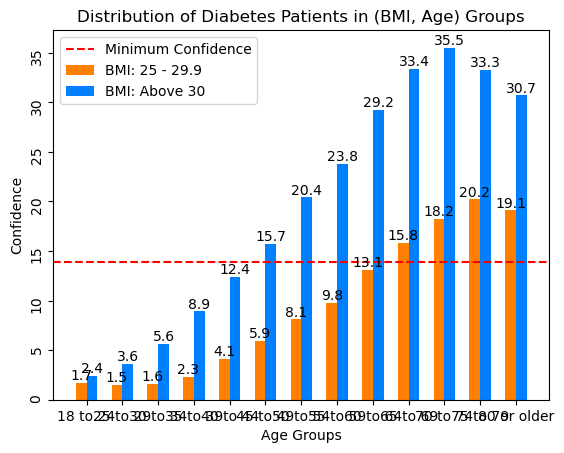

In [39]:
ages = list(df["Age"].unique())
names = ["18 to 24", "25 to 29", "30 to 34", "35 to 39", "40 to 44", "45 to 49",
         "50 to 54", "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 or older"]
ages.sort()
bar_positions_group1 = np.arange(len(ages))
bar_positions_group2 = bar_positions_group1 + 0.3

for i in range(len(ages)):
    for j in range(2):
        c = f"Age_{ages[i]}"
        vector = df_new[c] & df_new[f"BMI_{2+j}"]
        pop = df_save[c] & df_save[f"BMI_{2+j}"]
        conf = vector.sum(axis=0) / pop.sum(axis=0)
        if j == 0:
            bar = plt.bar(bar_positions_group1[i], round(conf*100, 1), color=(1,0.5,0), width=0.3, label='BMI: 25 - 29.9')
        else:
            bar = plt.bar(bar_positions_group2[i], round(conf*100, 1), color=(0,0.5,1), width=0.3, label="BMI: Above 30")
        plt.bar_label(bar)
    # plt.bar(names[i], round(minconf*100, 2), color=(1,0.5,0,(i+1)/len(ages)), width=0.5)
plt.axhline(y=round(minconf*100, 2), color=(1,0,0), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("Age Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Diabetes Patients in (BMI, Age) Groups")
plt.xticks(bar_positions_group1 + 0.3 / 2, names)
plt.legend(["Minimum Confidence", "BMI: 25 - 29.9", "BMI: Above 30"], loc="upper left")
plt.show()

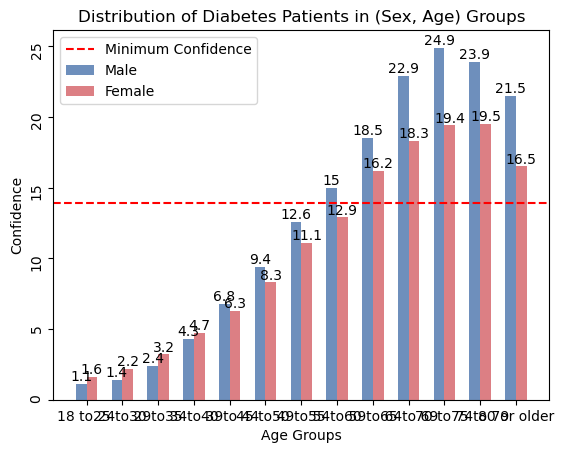

In [40]:
ages = list(df["Age"].unique())
names = ["18 to 24", "25 to 29", "30 to 34", "35 to 39", "40 to 44", "45 to 49",
         "50 to 54", "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 or older"]
ages.sort()
bar_positions_group1 = np.arange(len(ages))
bar_positions_group2 = bar_positions_group1 + 0.3

for i in range(len(ages)):
    for j in range(2):
        if j == 0:
            c = f"Age_{ages[i]}"
            vector = df_new[c] & df_new[f"Male"]
            pop = df_save[c] & df_save[f"Male"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group1[i], round(conf*100, 1), color=(110/255,143/255,188/255), width=0.3, label='Male')
        else:
            c = f"Age_{ages[i]}"
            vector = df_new[c] & df_new[f"Female"]
            pop = df_save[c] & df_save[f"Female"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group2[i], round(conf*100, 1), color=(220/255,127/255,132/255), width=0.3, label='Female')
        plt.bar_label(bar)
    # plt.bar(names[i], round(minconf*100, 2), color=(1,0.5,0,(i+1)/len(ages)), width=0.5)
plt.axhline(y=round(minconf*100, 2), color=(1,0,0), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("Age Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Diabetes Patients in (Sex, Age) Groups")
plt.xticks(bar_positions_group1 + 0.3 / 2, names)
plt.legend(["Minimum Confidence", "Male", "Female"], loc="upper left")
plt.show()

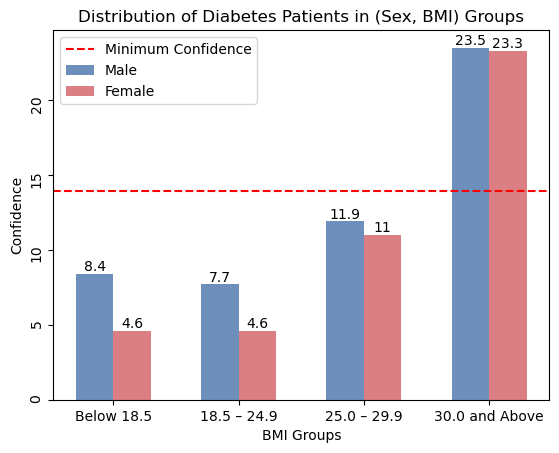

In [41]:
columns = ["BMI_0", "BMI_1", "BMI_2", "BMI_3"]
names = ["Below 18.5", "18.5 – 24.9", "25.0 – 29.9", "30.0 and Above"]
bar_positions_group1 = np.arange(len(columns))
bar_positions_group2 = bar_positions_group1 + 0.3

for i in range(len(columns)):
    for j in range(2):
        if j == 0:
            c = columns[i]
            vector = df_new[c] & df_new[f"Male"]
            pop = df_save[c] & df_save[f"Male"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group1[i], round(conf*100, 1), color=(110/255,143/255,188/255), width=0.3, label='Male')
        else:
            c = columns[i]
            vector = df_new[c] & df_new[f"Female"]
            pop = df_save[c] & df_save[f"Female"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group2[i], round(conf*100, 1), color=(220/255,127/255,132/255), width=0.3, label='Female')
        plt.bar_label(bar)
    # plt.bar(names[i], round(minconf*100, 2), color=(1,0.5,0,(i+1)/len(ages)), width=0.5)
plt.axhline(y=round(minconf*100, 2), color=(1,0,0), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("BMI Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Diabetes Patients in (Sex, BMI) Groups")
plt.xticks(bar_positions_group1 + 0.3 / 2, names)
plt.legend(["Minimum Confidence", "Male", "Female"], loc="upper left")
plt.show()

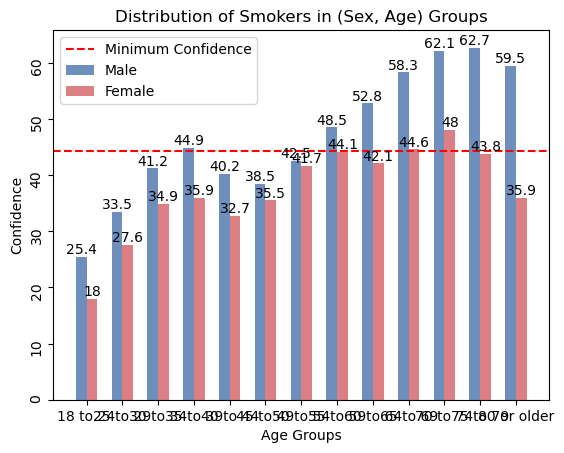

In [42]:
ages = list(df["Age"].unique())
names = ["18 to 24", "25 to 29", "30 to 34", "35 to 39", "40 to 44", "45 to 49",
         "50 to 54", "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 or older"]
ages.sort()
bar_positions_group1 = np.arange(len(ages))
bar_positions_group2 = bar_positions_group1 + 0.3

for i in range(len(ages)):
    for j in range(2):
        if j == 0:
            c = f"Age_{ages[i]}"
            vector = df_save[c] & df_save[f"Male"] & df_save["Smoker"]
            pop = df_save[c] & df_save[f"Male"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group1[i], round(conf*100, 1), color=(110/255,143/255,188/255), width=0.3, label='Male')
        else:
            c = f"Age_{ages[i]}"
            vector = df_save[c] & df_save[f"Female"] & df_save["Smoker"]
            pop = df_save[c] & df_save[f"Female"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group2[i], round(conf*100, 1), color=(220/255,127/255,132/255), width=0.3, label='Female')
        plt.bar_label(bar)
    # plt.bar(names[i], round(minconf*100, 2), color=(1,0.5,0,(i+1)/len(ages)), width=0.5)
temp = df_save["Smoker"].sum(axis=0) / len(df_save)
plt.axhline(y=round(temp*100, 2), color=(1,0,0), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("Age Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Smokers in (Sex, Age) Groups")
plt.xticks(bar_positions_group1 + 0.3 / 2, names)
plt.legend(["Minimum Confidence", "Male", "Female"], loc="upper left")
plt.show()

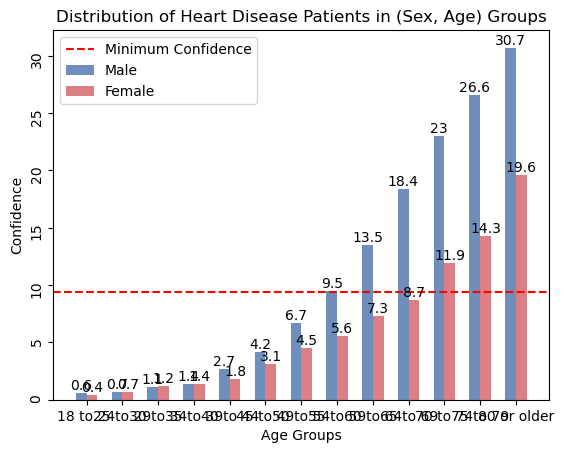

In [43]:
ages = list(df["Age"].unique())
names = ["18 to 24", "25 to 29", "30 to 34", "35 to 39", "40 to 44", "45 to 49",
         "50 to 54", "55 to 59", "60 to 64", "65 to 69", "70 to 74", "75 to 79", "80 or older"]
ages.sort()
bar_positions_group1 = np.arange(len(ages))
bar_positions_group2 = bar_positions_group1 + 0.3

for i in range(len(ages)):
    for j in range(2):
        if j == 0:
            c = f"Age_{ages[i]}"
            vector = df_save[c] & df_save[f"Male"] & df_save["HeartDiseaseorAttack"]
            pop = df_save[c] & df_save[f"Male"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group1[i], round(conf*100, 1), color=(110/255,143/255,188/255), width=0.3, label='Male')
        else:
            c = f"Age_{ages[i]}"
            vector = df_save[c] & df_save[f"Female"] & df_save["HeartDiseaseorAttack"]
            pop = df_save[c] & df_save[f"Female"]
            conf = vector.sum(axis=0) / pop.sum(axis=0)
            bar = plt.bar(bar_positions_group2[i], round(conf*100, 1), color=(220/255,127/255,132/255), width=0.3, label='Female')
        plt.bar_label(bar)
    # plt.bar(names[i], round(minconf*100, 2), color=(1,0.5,0,(i+1)/len(ages)), width=0.5)
temp = df_save["HeartDiseaseorAttack"].sum(axis=0) / len(df_save)
plt.axhline(y=round(temp*100, 2), color=(1,0,0), linestyle='dashed', label="Minimum Confidence")
plt.yticks(rotation="vertical")
plt.xlabel("Age Groups")
plt.ylabel("Confidence")
plt.title("Distribution of Heart Disease Patients in (Sex, Age) Groups")
plt.xticks(bar_positions_group1 + 0.3 / 2, names)
plt.legend(["Minimum Confidence", "Male", "Female"], loc="upper left")
plt.show()